# Infer ***endoplasmic reticulum (ER)*** - part 8️⃣

--------------

## OVERVIEW
In notesbooks 4-9, we will go how each organelle is segmented. These segmentation workflows are completely independent of each other and can be run in any order. Additionally, the entire image will be processed in this notebook, irrespective of the single cells identified in notebooks 1-3. The cell mask will be applied to the organelle segmentation outputs before quantification (as outlined in [10_regionprops](./10_regionprops.ipynb)). 

This notebook goes through the workflow steps to segment the ***ER*** -- one of the six organelles of interest.

## OBJECTIVE: ✅ Infer sub-cellular component  ***ER***  
Segment the ***ER*** from a single channel (membrane marker). This workflow was optimized for images of fluorescently tagged Sec61beta, a membrane protein. An instance segmentation is not done here as we assume the ER is one coninuous organelle.


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys

import numpy as np

from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         edge_preserving_smoothing_3d )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.vessel import filament_2d_wrapper
                                                 
from skimage.measure import label


import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc.core.img import *
from infer_subc.organelles import get_cellmask, get_nuclei, get_cytoplasm
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )  

%load_ext autoreload
%autoreload 2

## Get and load Image for processing

In [6]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) /  "Documents/Python_Scripts/Infer-subc"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [7]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

---------------------

## infer ***ER***

## summary of steps 

➡️ INPUT
- select single channel containing the mitochondria marker (channel number = user input)

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)

CORE-PROCESSING
- apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)
- (*OPTIONAL*) apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)
- combine the two segmentations with logical *OR*

POST-PROCESSING
- fill holes (hole size = user input)
- remove small objects (object size = user input)

OUTPUT ➡️ 
- label all ER "objects" 1/True 
- save labeled ***ER*** (ER) as unsigned integer 16-bit tif files

> The Allen Cell Segmenter procedure included an edge proserving smoothing method followed by the "filament" thresholding method (find the Sec61b script [here](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_sec61b.py)). We have opted to also include to MO threshold method as it segments densely packed ER better.

## EXTRACT prototype

In [8]:
###################
# INPUT
###################
raw_ER = select_channel_from_raw(img_data, ER_CH)

## PRE-PROCESSING prototype

In [9]:
###################
# PRE_PROCESSING
###################
median_sz = 3
gauss_sig = 2.0

struct_img = scale_and_smooth(raw_ER,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)

## CORE PROCESSING prototype

In [10]:
###################
# CORE_PROCESSING
###################
# segment the ER with this global and local thresholding method
thresh_method = 'tri'
cell_wise_min_area = 1200
thresh_adj = 0.7

bw_MO_test = masked_object_thresh(struct_img,
                          global_method=thresh_method, 
                          cutoff_size=cell_wise_min_area, 
                          local_adjust=thresh_adj)


# apply the 2D or 3D versions of the AICSsegmentation filament filter with multiple scales
fil_method = "3D"

bw_filament_test = filament_filter_3(struct_img, 1, 0.005, 2, 0.005, 0, 0, fil_method)


# combine the two segmentations together
bw_test = np.logical_or(bw_MO_test, bw_filament_test)

## POST-PROCESSING prototype

In [11]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 4

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_test, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

## LABELING prototype

We assume that the ER is one continuous object.

In [12]:
###################
# LABELING
###################
ER_labels = label_bool_as_uint16(cleaned_img2)

In [13]:
ER_labels.dtype

dtype('uint16')

## Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [14]:
viewer = napari.Viewer()

In [15]:
viewer.add_image(
    struct_img)

viewer.add_image(
    cleaned_img2,
    opacity=0.3,)

viewer.add_labels(
    ER_labels,
    opacity=0.3)

<Labels layer 'ER_labels' at 0x292671b4850>

## SAVE inferred golgi to .tif file

In [12]:
out_file_n = export_inferred_organelle(ER_labels, "ER", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_14_Unmixing-ER


----------
## DEFINE `_infer_ER` function

Based on the _prototyping_ above define the function to infer the er.  

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [13]:
##########################
#  infer_ER
##########################
def _infer_ER(
              in_img: np.ndarray,
              ER_ch: int,
              median_sz: int,
              gauss_sig: float,
              MO_thresh_method: str,
              MO_cutoff_size: float,
              MO_thresh_adj: float,
              fil_scale_1: float,
              fil_cut_1: float,
              fil_scale_2: float, 
              fil_cut_2: float, 
              fil_scale_3: float, 
              fil_cut_3: float,
              fil_method: str,
              min_hole_w: int,
              max_hole_w: int,
              small_obj_w: int,
              fill_filter_method: str
              ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    ER = select_channel_from_raw(in_img, ER_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    # er = normalized_edge_preserving_smoothing(er)
    struct_img =  scale_and_smooth(ER,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    bw1 = masked_object_thresh(struct_img, 
                                    global_method=MO_thresh_method, 
                                    cutoff_size=MO_cutoff_size, 
                                    local_adjust=MO_thresh_adj)

    bw2 = filament_filter_3(struct_img, fil_scale_1, fil_cut_1, fil_scale_2, fil_cut_2, fil_scale_3, fil_cut_3, fil_method)

    struct_obj = np.logical_or(bw1, bw2)
    
    ###################
    # POST_PROCESSING
    ################### 
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    
    # ENSURE THAT there is ONLY ONE ER
    struct_obj = label_bool_as_uint16(struct_obj)

    return struct_obj 

# DEFINE  `_fixed_infer_ER` function

In [14]:
##########################
#  fixed_infer_ER
##########################
def _fixed_infer_ER(in_img: np.ndarray ) -> np.ndarray:
    """
    Procedure to infer endoplasmic rediculum from linearly unmixed input with *fixed parameters*

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    ER_ch = 5
    median_sz = 3
    gauss_sig = 2.0
    MO_thresh_method = 'tri'
    MO_cutoff_size = 1200
    MO_thresh_adj = 0.7
    fil_scale_1 = 1
    fil_cut_1 = 0.005
    fil_scale_2 = 2
    fil_cut_2 = 0.005
    fil_scale_3 = 0
    fil_cut_3 = 0
    fil_method = "3D"
    min_hole_w = 0
    max_hole_w = 0
    small_obj_w = 4
    method = "3D"

    return _infer_ER(
        in_img,
        ER_ch,
        median_sz,
        gauss_sig,
        MO_thresh_method,
        MO_cutoff_size,
        MO_thresh_adj,
        fil_scale_1,
        fil_cut_1,
        fil_scale_2,
        fil_cut_2,
        fil_scale_3,
        fil_cut_3,
        fil_method,
        min_hole_w,
        max_hole_w,
        small_obj_w,
        method)

# TEST  `_infer_ER` function defined above

In [15]:
_ER_object =  _fixed_infer_ER(img_data) 

_ER_object.dtype

dtype('uint16')

In [16]:
np.all(ER_labels == _ER_object)

True

------------------

# TEST `infer_ER` exported functions

The prototype _infer_ER was copied to the [.organelles.ER](../infer_subc/organelles/ER.py) sub-module.

In [17]:
from infer_subc.organelles import fixed_infer_ER

ER_object =  fixed_infer_ER(img_data) 

In [18]:
np.all(_ER_object == ER_object)

True

## Visualize  2


In [19]:
viewer.add_image(
    _ER_object,
    opacity=0.3)

viewer.add_labels(
    ER_object,
    opacity=0.3)

<Labels layer 'ER_object' at 0x204a914f250>

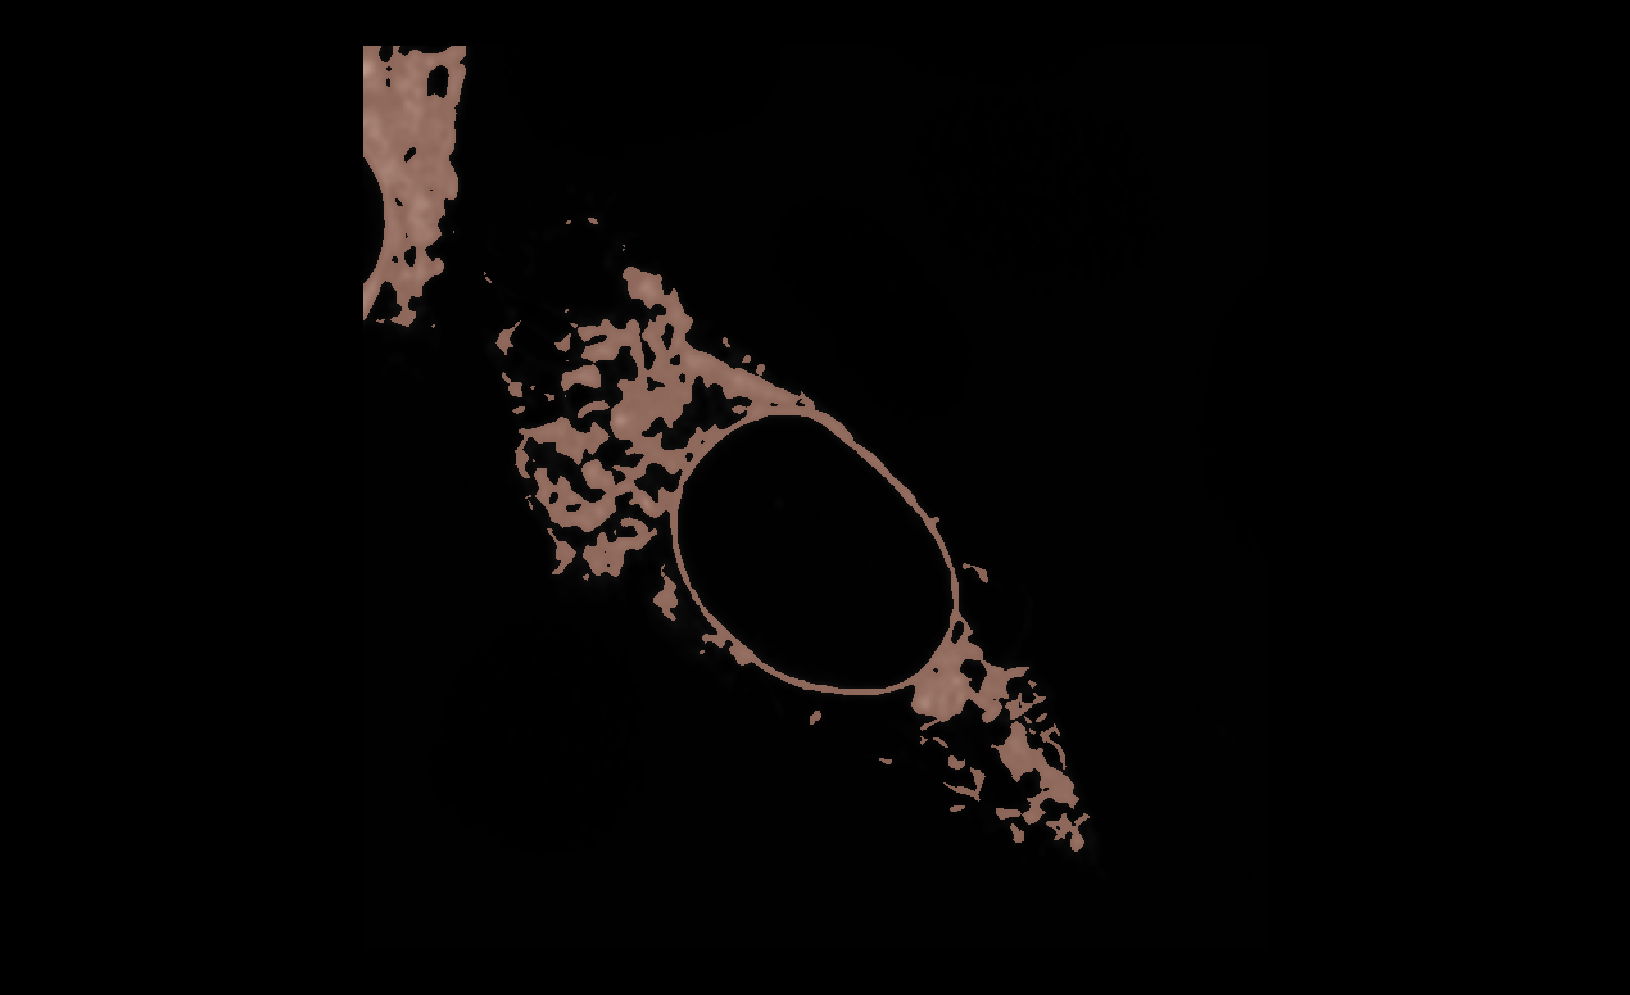

In [20]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-------------
## SUMMARY

The above details how the ER object is inferred.  

### NEXT: INFER LIPID BODY

proceed to [09_infer_lipid_droplet.ipynb](./09_infer_lipid_droplet.ipynb)
